# Time series model fitting

Here the time series data will be observed and evaluated in order to fit a time series model to predict new data

To reach that aim, should be considered:

- Look for segments that duplicated the temporal observations
- indexing the data by the time variable
- Sampling the data and build train and test splits
- Evaluate series and look for seasonability
- Make seasonal decomposition
- Perform grid seach for discovering the more suitable parameters
- fit the model
- Evaluate the model on test set

In [1]:
#LOADS LIBRARIES
import os
import sys
import warnings
warnings.simplefilter('ignore')
import pickle
#import dill as pickle

import numpy as np
import pandas as pd
import math

import time 
import datetime
from dateutil.relativedelta import relativedelta

import json

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
#sns.reset_orig
#matplotlib.rc_file_defaults()

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import itertools

from sklearn.metrics import classification_report, confusion_matrix, roc_curve,\
                            precision_recall_curve, roc_auc_score, balanced_accuracy_score, log_loss, \
                            mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error

In [4]:
# Defines the storage directories
OUTPUT_DIR = os.getcwd() + '/results/'

# Temporal series analysis

In [5]:
#Call the analysis data frame

df_analysis = pd.read_pickle(OUTPUT_DIR + 'df_temporalsales_s2.pkl')

print(df_analysis.shape)
print('\n')

for c in df_analysis.columns.tolist():
    print(c)

(51843, 7)


date
set_description
q_current
store
q_current_log
mes
dia_semana


In [6]:
#Filtering the data to optimize machine performance (with a more powerful machine, this could change)
df_analysis = df_analysis[df_analysis['date']>datetime.datetime(2021,11,30)].copy()
print(df_analysis.shape)

(3888, 7)


In [7]:
#Sort the data by the consecutive date
df_analysis = df_analysis.sort_values(['date','store']).reset_index(drop=True)
df_analysis['date2'] = df_analysis['date']
df_analysis

,date,set_description,q_current,store,q_current_log,mes,dia_semana,date2
0,2021-11-30 00:30:00,1_TRAIN,74.0,1.0,4.317488,11,1,2021-11-30 00:30:00
1,2021-11-30 00:30:00,1_TRAIN,70.0,5.0,4.262680,11,1,2021-11-30 00:30:00
2,2021-11-30 00:30:00,1_TRAIN,66.0,9.0,4.204693,11,1,2021-11-30 00:30:00
3,2021-11-30 01:00:00,1_TRAIN,64.0,1.0,4.174387,11,1,2021-11-30 01:00:00
4,2021-11-30 01:00:00,1_TRAIN,62.0,5.0,4.143135,11,1,2021-11-30 01:00:00
...,...,...,...,...,...,...,...,...
3883,2021-12-26 23:30:00,1_TRAIN,65.0,5.0,4.189655,12,6,2021-12-26 23:30:00
3884,2021-12-26 23:30:00,1_TRAIN,31.0,9.0,3.465736,12,6,2021-12-26 23:30:00
3885,2021-12-27 00:00:00,1_TRAIN,55.0,1.0,4.025352,12,0,2021-12-27 00:00:00
3886,2021-12-27 00:00:00,1_TRAIN,73.0,5.0,4.304065,12,0,2021-12-27 00:00:00


In [8]:
#Summary table of interes variable in front of segments
df_stores_summary = df_analysis.groupby(['store','set_description'] ).agg(
        min_date = ('date','min'),
        max_date = ('date','max'),
        observations = ('date','count'),
        avg_sales = ('q_current', 'mean'),
    )

df_stores_summary = df_stores_summary.reset_index()
df_stores_summary

,store,set_description,min_date,max_date,observations,avg_sales
0,1.0,1_TRAIN,2021-11-30 00:30:00,2021-12-27,1296,46.544882
1,5.0,1_TRAIN,2021-11-30 00:30:00,2021-12-27,1296,55.312371
2,9.0,1_TRAIN,2021-11-30 00:30:00,2021-12-27,1296,23.801698


In [29]:
#Taking appart the stores, because each of one of them have its ouwn time-series

seleted_segment = 'store5'

if seleted_segment == 'store1':
    df_store = df_analysis[df_analysis['store']==1].copy()
if seleted_segment == 'store5':
    df_store = df_analysis[df_analysis['store']==5].copy()
if seleted_segment == 'store9':
    df_store = df_analysis[df_analysis['store']==9].copy()


print(df_store.shape)
df_store

(1296, 8)


,date,set_description,q_current,store,q_current_log,mes,dia_semana,date2
1,2021-11-30 00:30:00,1_TRAIN,70.000000,5.0,4.262680,11,1,2021-11-30 00:30:00
4,2021-11-30 01:00:00,1_TRAIN,62.000000,5.0,4.143135,11,1,2021-11-30 01:00:00
7,2021-11-30 01:30:00,1_TRAIN,112.500000,5.0,4.731803,11,1,2021-11-30 01:30:00
10,2021-11-30 02:00:00,1_TRAIN,68.666667,5.0,4.243722,11,1,2021-11-30 02:00:00
13,2021-11-30 02:30:00,1_TRAIN,59.666667,5.0,4.105394,11,1,2021-11-30 02:30:00
...,...,...,...,...,...,...,...,...
3874,2021-12-26 22:00:00,1_TRAIN,56.000000,5.0,4.043051,12,6,2021-12-26 22:00:00
3877,2021-12-26 22:30:00,1_TRAIN,56.000000,5.0,4.043051,12,6,2021-12-26 22:30:00
3880,2021-12-26 23:00:00,1_TRAIN,46.000000,5.0,3.850148,12,6,2021-12-26 23:00:00
3883,2021-12-26 23:30:00,1_TRAIN,65.000000,5.0,4.189655,12,6,2021-12-26 23:30:00


In [30]:
#Set the date as index

df_store.set_index('date2', inplace=True)


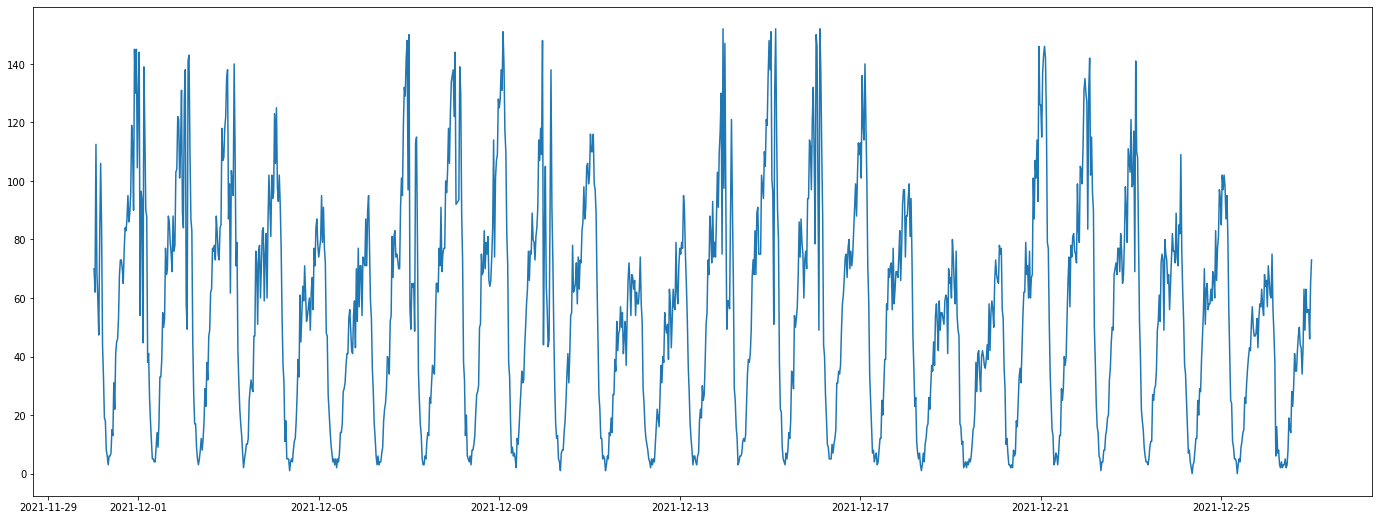

In [31]:
f, ax = plt.subplots(figsize=(24,9))
plt.plot(df_store.index, df_store['q_current'])

## TRAIN, TEST SPLIT

##### Ussually here is used the test_train_split of sklearn module, but here the partitition should be temporal, where train data must be older than test data

In [32]:
# Split data set into train and test sets

train_size = int(len(df_store)*0.75)
test_size = len(df_store) - train_size

df_train, df_test = df_store.iloc[0:train_size,:], df_store.iloc[train_size:len(df_store),:]


print(max(df_train['store']))

print('\n')
print(df_train.shape)
print(min(df_train['date']))
print(max(df_train['date']))

print('\n')
print(df_test.shape)
print(min(df_test['date']))
print(max(df_test['date']))

5.0


(972, 7)
2021-11-30 00:30:00
2021-12-20 06:00:00


(324, 7)
2021-12-20 06:30:00
2021-12-27 00:00:00


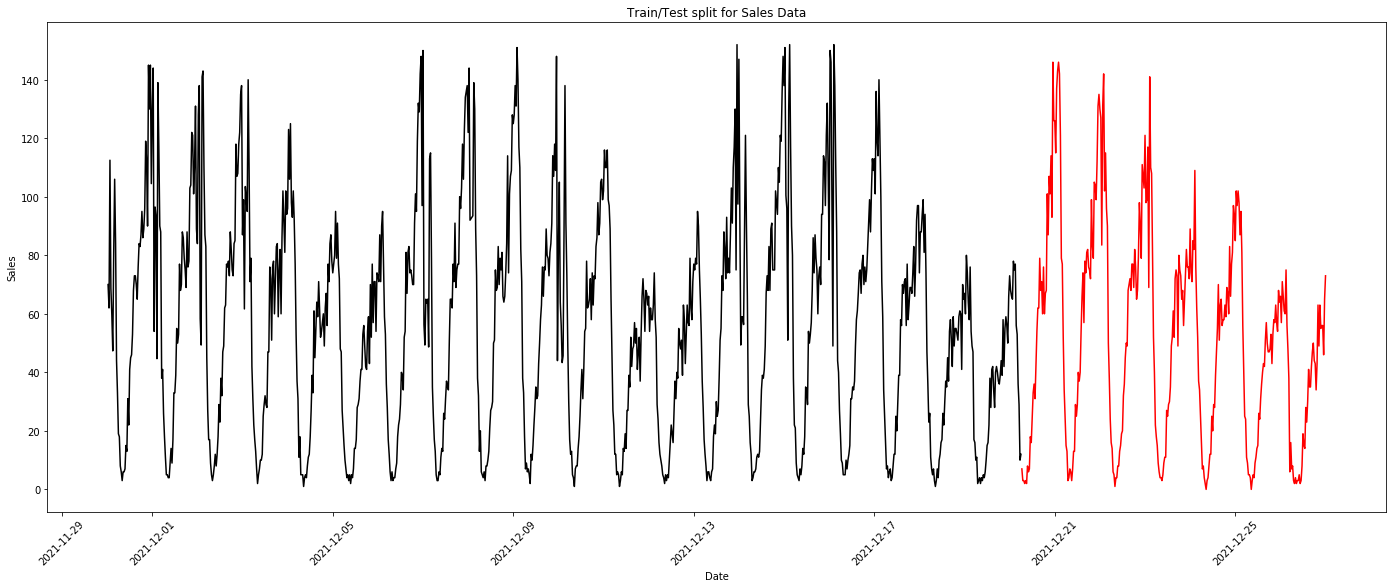

In [33]:
#Test and Train splits representation on time flow

f, ax = plt.subplots(figsize=(24,9))
plt.plot(df_train['q_current'], color = "black")
plt.plot(df_test['q_current'], color = "red")
plt.ylabel('Sales')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Sales Data")
plt.show()

# Time series model grid search

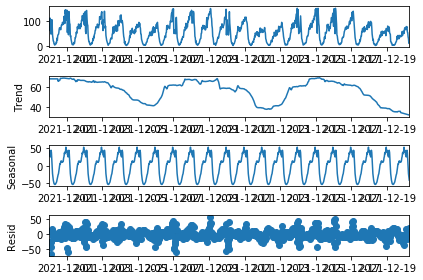

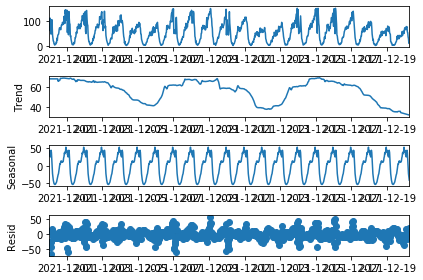

In [34]:
#Seasonal descomposition

decompose_data = seasonal_decompose(df_train[['q_current']], model="additive", extrapolate_trend='freq', period=48)

decompose_data.plot()

In [35]:
#Stacionarity test

dftest = adfuller(df_train['q_current'], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -9.9253293747959
2. P-Value :  2.91725274190087e-17
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 958
5. Critical Values :
	 1% :  -3.4371943720994165
	 5% :  -2.8645616735407002
	 10% :  -2.568378906211183


### Here can be observed stacionarity, it should be corrected, but for better manipulation, it will be opted for ARIMA model

In [36]:
# SARIMA GRID SEARCH
# Define the p, d and q parameters for value between 0-3 and iterate for all the value in the range

if seleted_segment == 'null':

    df_train_ = df_train.iloc[-500:,:] #amples the series to optimize the computations

    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    # Generate all different combinations of seasonal p, q and q 
    seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
    params=[]
    seasonal=[]
    aic=[]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(df_train_['q_current'],
                                            order=param,
                                            seasonal_order=param_seasonal,                                    
                                            enforce_stationarity=False,                                          
                                            enforce_invertibility=False)

            #append all the parameters and result AIC value
            results = mod.fit()
            params.append(param)
            seasonal.append(param_seasonal)
            aic.append(results.aic)
            parameter_options=pd.DataFrame({'params':params,'seasonal_params':seasonal,'AIC':aic})

    #sort the AIC value to find the best fitted model
    parameter_options.sort_values(by='AIC')

In [37]:
#The lowest AIC to select the best ARIMAX order to model the time series

#(1, 0, 1)	(2, 1, 2, 24)	17196.063253
#(2, 0, 2)	(2, 2, 2, 24)	3382.951955

if seleted_segment == 'null':

    parameter_options.to_pickle(OUTPUT_DIR + 'grid_parameter_options.pkl')
    print(parameter_options.shape)

    parameter_options.sort_values(by='AIC')
    
else:
    parameter_options = pd.read_pickle(OUTPUT_DIR + 'grid_parameter_options.pkl')


In [38]:
parameter_options.sort_values(by='AIC')

,params,seasonal_params,AIC
566,"(2, 0, 2)","(2, 2, 2, 24)",3382.951955
314,"(1, 0, 2)","(1, 2, 2, 24)",3385.504141
557,"(2, 0, 2)","(1, 2, 2, 24)",3387.092483
404,"(1, 1, 2)","(2, 2, 2, 24)",3387.428694
296,"(1, 0, 1)","(2, 2, 2, 24)",3389.368265
...,...,...,...
1,"(0, 0, 0)","(0, 0, 1, 24)",5136.821715
33,"(0, 0, 1)","(0, 2, 0, 24)",5145.516850
3,"(0, 0, 0)","(0, 1, 0, 24)",5215.350912
0,"(0, 0, 0)","(0, 0, 0, 24)",5462.636559


In [39]:
# Trainning the model with the best parameters observed in grid search

prediction=[]
my_order = (1, 0, 1)
my_seasonal_order = (2, 1, 2, 24)

initial=len(df_train)

model = sm.tsa.statespace.SARIMAX(df_train['q_current'], 
                                  order=my_order, 
                                  seasonal_order=my_seasonal_order)
results=model.fit()

print(results.summary().tables[1])

C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9187      0.013     72.405      0.000       0.894       0.944
ma.L1         -0.5131      0.025    -20.858      0.000      -0.561      -0.465
ar.S.L24      -1.0024      0.062    -16.279      0.000      -1.123      -0.882
ar.S.L48      -0.0025      0.061     -0.041      0.968      -0.122       0.117
ma.S.L24      -0.0081      0.775     -0.010      0.992      -1.527       1.510
ma.S.L48      -0.9918      0.799     -1.242      0.214      -2.557       0.574
sigma2       187.9101    150.781      1.246      0.213    -107.615     483.436


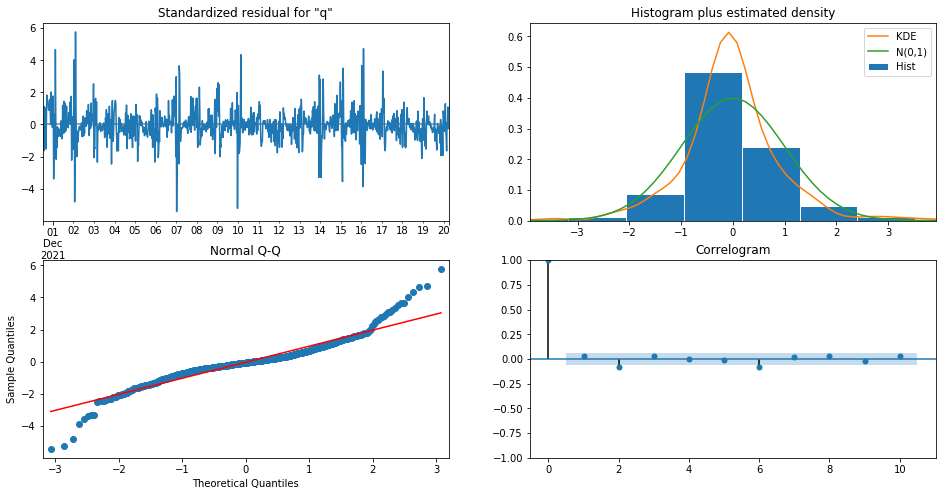

In [40]:
#Explore whether the error are randomly distributed along cero and  normal distributed
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [41]:
# Computes some performance metrics of the model in train set

df_train['prediction'] = results.predict()
df_train

print()
mse = mean_squared_error(df_train['q_current'], df_train['prediction'])
rmse = round(np.sqrt(mse),2)

print('rmse: ', rmse)
print('% r2: ', r2_score(df_train['q_current'], df_train['prediction']))


rmse:  17.37
% r2:  0.7909386878049938


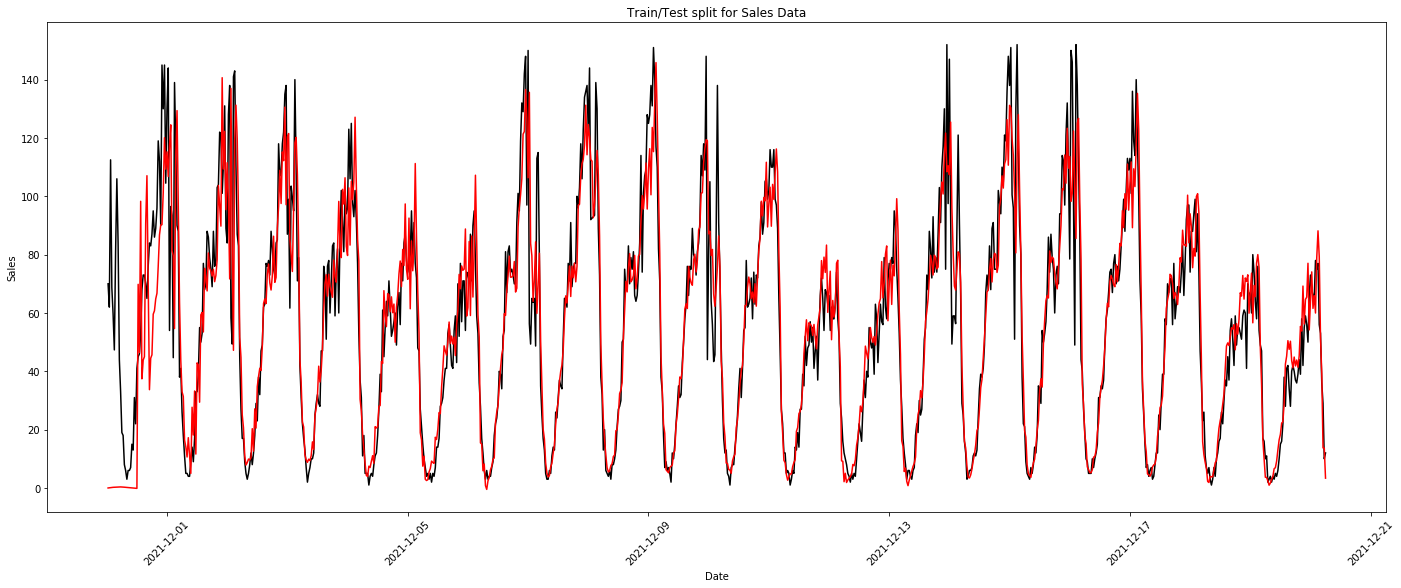

In [42]:
#Graphical comparison between real vs prediction for train set

f, ax = plt.subplots(figsize=(24,9))
plt.plot(df_train['q_current'], color = "black")
plt.plot(df_train['prediction'], color = "red")
plt.ylabel('Sales')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Sales Data")
plt.show()

In [43]:
# Computes some performance metrics of the model in test set

pred_uc = results.get_forecast(steps=len(df_test))
pred_ci = pred_uc.conf_int()

df_test['prediction'] = pred_uc.predicted_mean
df_test

target_decription = df_test['prediction'].describe()
print(target_decription)

mse = mean_squared_error(df_test['q_current'], df_test['prediction'])
rmse = round(np.sqrt(mse),2)
pp_error = rmse/target_decription['mean']
r2 = r2_score(df_test['q_current'], df_test['prediction'])

print('\n')
print('rmse: ', rmse)
print('% error: ', pp_error)
print('% r2: ', r2)

dc_model_metrics = {
    'rmse':rmse,
    'pp_error':pp_error,
    'r2':r2
}


count    324.000000
mean      55.077331
std       32.369989
min       -0.989138
25%       24.255310
50%       64.496958
75%       86.816978
max      105.830767
Name: prediction, dtype: float64


rmse:  17.02
% error:  0.3090200561778285
% r2:  0.7817588290896909


### Looks at the rmse < std which indicates that the model is good enough
### Also the r2 is above 0.7
### The % error is not higher than 0.5

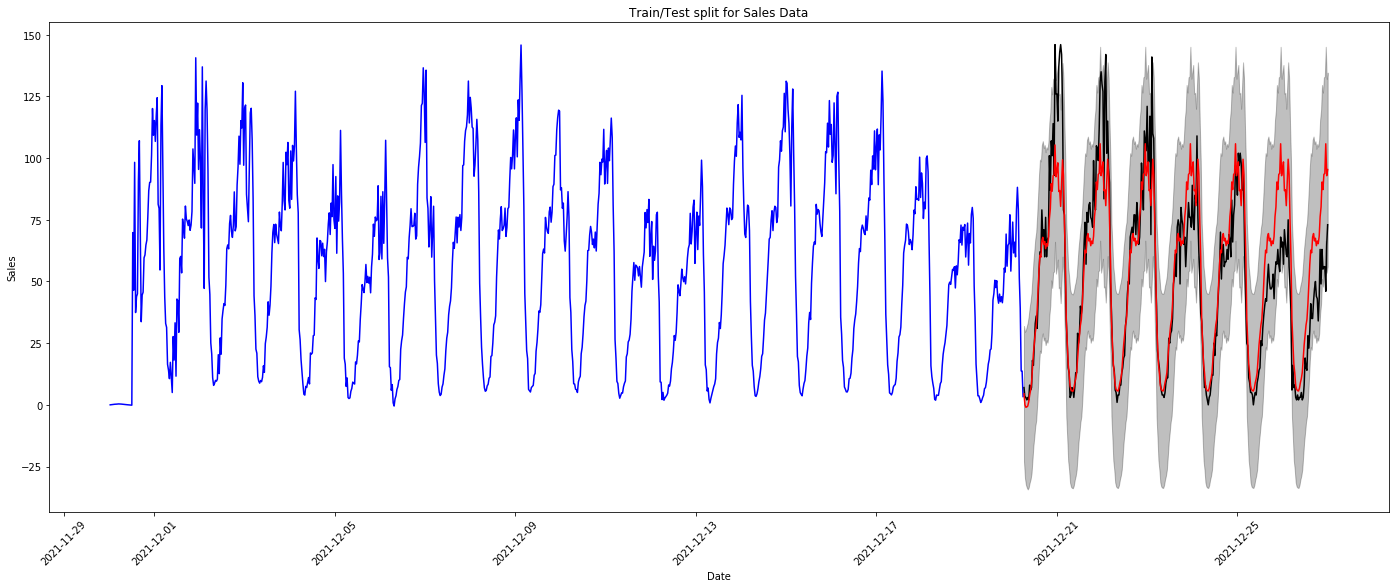

In [44]:
#Graphical comparison between real vs prediction for test set

f, ax = plt.subplots(figsize=(24,9))
plt.plot(df_train['prediction'], color = "blue")
plt.plot(df_test['q_current'], color = "black")
plt.plot(df_test['prediction'], color = "red")
plt.ylabel('Sales')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Sales Data")

ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)

plt.show()



# Re-fit the model with the most recent data (just when is working with temporal series)

In [45]:
#Refitting to the last available data

model = sm.tsa.statespace.SARIMAX(df_store['q_current'], 
                                  order=my_order, 
                                  seasonal_order=my_seasonal_order)
results=model.fit()

print(results.summary().tables[1])

C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9265      0.010     92.068      0.000       0.907       0.946
ma.L1         -0.5228      0.020    -26.091      0.000      -0.562      -0.484
ar.S.L24      -0.9871      0.053    -18.722      0.000      -1.090      -0.884
ar.S.L48       0.0117      0.052      0.224      0.823      -0.091       0.114
ma.S.L24      -0.0353      0.621     -0.057      0.955      -1.252       1.181
ma.S.L48      -0.9624      0.569     -1.692      0.091      -2.078       0.153
sigma2       169.1042     99.770      1.695      0.090     -26.441     364.649


In [46]:
#Saves the total procedure for the choosen model

if seleted_segment == 'store1': 
    
    pickle.dump(results, open( OUTPUT_DIR + 'store1_sales_model.pkl', 'wb'))
    
    with open(OUTPUT_DIR + 'store1_model_metrics.json', 'w') as fp:
        json.dump(dc_model_metrics, fp)
    
if seleted_segment == 'store5': 
    
    pickle.dump(results, open( OUTPUT_DIR + 'store5_sales_model.pkl', 'wb'))
    
    with open(OUTPUT_DIR +'store5_model_metrics.json', 'w') as fp:
        json.dump(dc_model_metrics, fp)
    
if seleted_segment == 'store9': 
    
    pickle.dump(results, open( OUTPUT_DIR + 'store9_sales_model.pkl', 'wb'))
    
    with open(OUTPUT_DIR +'store9_model_metrics.json', 'w') as fp:
        json.dump(dc_model_metrics, fp)